<a href="https://colab.research.google.com/github/sohumgautam17/nexus_ai_coursework/blob/main/Week3_UNET_Pretrained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import torch
from torch import nn # This imports the neural network library (All the features we need are here)

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F

!pip install monai
import monai
from monai.losses import DiceLoss

!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm

import os
import glob
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)

2.5.1+cu121


In [38]:
import kagglehub
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")
print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1


In [60]:
def load_dataset(path):
    # Remove leading slash from Image path and fix case
    image_files = sorted(glob.glob(os.path.join(path, "Image/*.jpg")))  # Note: .jpg not .png
    mask_files = sorted(glob.glob(os.path.join(path, "Mask/*.png")))

    images = []
    masks = []

    for img_path, mask_path in zip(image_files, mask_files):
        img = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path))
        images.append(img)
        masks.append(mask)

    return images, masks

# Load all images and masks
images, masks = load_dataset(path)

290
(402, 620, 3)


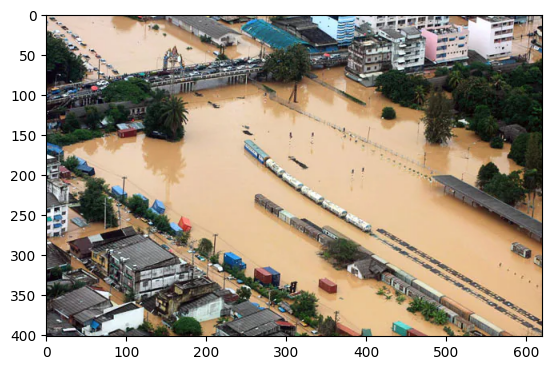

In [61]:
image_num = 289 #@param {type:"raw"}
print(len(images))
print(images[image_num].shape)
plt.imshow(images[image_num])

290
(402, 620)


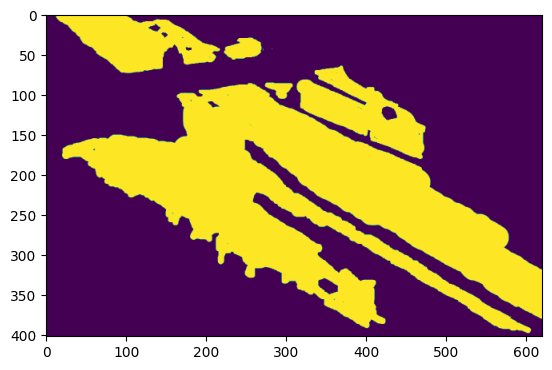

In [79]:
print(len(masks))
print(masks[image_num].shape)
plt.imshow(masks[image_num])

In [154]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

image_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], p=1.0)

mask_transform = A.Compose([
    A.Resize(512, 512),
    ToTensorV2()
], p=1.0)

#Custom Dataset

In [155]:
class FloodDataset():
  def __init__(self, images, masks):
    self.images = images
    self.masks = masks

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img = self.images[index]
    mask = self.masks[index]

    img_transformed = image_transform(image=img)['image']
    mask_transformed = mask_transform(image=mask)['image']

    return img_transformed, mask_transformed


In [135]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2)

print(f'print train images: {len(x_train)} train masks: {len(y_train)}')
print(f'print test images: {len(x_test)} test masks: {len(y_test)}')

In [144]:
train_dataset = FloodDataset(x_train, y_train)
test_dataset = FloodDataset(x_test, y_test)

print train images: 232 train masks: 232
print test images: 58 test masks: 58


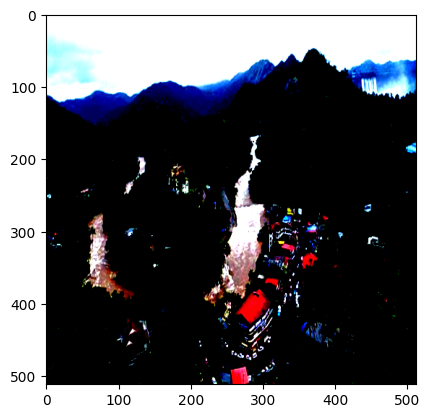

In [156]:
plt.imshow(train_dataset[2][0].permute(1, 2, 0))

In [157]:
train_dataset[2][1].shape

torch.Size([1, 512, 512])

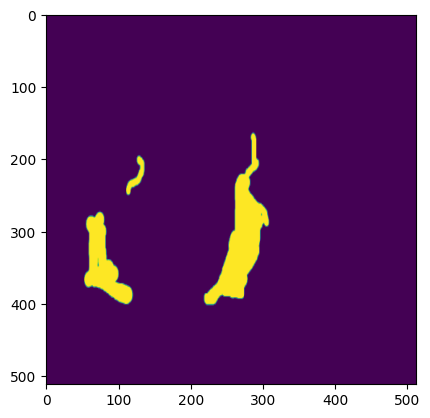

In [158]:
plt.imshow(train_dataset[2][1].permute(1, 2, 0))

In [159]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

#Model

![An Image](https://neuron-ai.at/wp-content/uploads/2022/11/neuronai-image-segmentation-segnet-architecture.png)


In [160]:
class Double_Conv(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
  def forward(self, x):
    return self.double_conv(x)


class Downsample(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels):
    super().__init__()
    self.downsample =  nn.Sequential(
      nn.MaxPool2d(kernel_size=2, stride=2),
      Double_Conv(in_channels, mid_channels, out_channels)
  )

  def forward(self, x):
    return self.downsample(x)


class Upsample(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels):
    super().__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv = Double_Conv(in_channels, mid_channels, out_channels)

  def forward(self, up_x, res_x):
    x = self.upsample(up_x)

    # print(up_x.size())
    # print(res_x.size())

    diffY = x.size()[2] - res_x.size()[2]
    diffX = x.size()[3] - res_x.size()[3]

    x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

    x = torch.cat([res_x, x], dim=1)

    return self.conv(x)

class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

In [161]:
class Unet(nn.Module):
  def __init__(self):
    super(Unet, self).__init__()
    self.down1 = Downsample(3, 64, 128)
    self.down2 = Downsample(128, 128, 256)
    self.down3 = Downsample(256, 256, 512)
    self.down4 = Downsample(512, 512, 1024)
    # For up1: 1024 + 512 = 1536 input channels after concat
    self.up1 = Upsample(1536, 512, 512)
    # For up2: 512 + 256 = 768 input channels after concat
    self.up2 = Upsample(768, 256, 256)
    # For up3: 256 + 128 = 384 input channels after concat
    self.up3 = Upsample(384, 128, 128)
    # For up4: 128 + 3 = 131 input channels after concat
    self.up4 = Upsample(131, 64, 64)
    self.outc = OutConv(64, 1)

  def forward(self, x):
    x1 = self.down1(x)
    x2 = self.down2(x1)
    x3 = self.down3(x2)
    x4 = self.down4(x3)
    x5 = self.up1(x4, x3)
    x6 = self.up2(x5, x2)
    x7 = self.up3(x6, x1)
    x8 = self.up4(x7, x)
    return self.outc(x8)

model = Unet()

In [162]:
# summary(model, (3, 512, 512))  # Specify device for summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1          [-1, 3, 256, 256]               0
            Conv2d-2         [-1, 64, 256, 256]           1,792
       BatchNorm2d-3         [-1, 64, 256, 256]             128
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 256, 256]          73,856
       BatchNorm2d-6        [-1, 128, 256, 256]             256
              ReLU-7        [-1, 128, 256, 256]               0
       Double_Conv-8        [-1, 128, 256, 256]               0
        Downsample-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
           Conv2d-14        [-1, 256, 1

In [163]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
dice_loss = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, test_loader, criterion, dice_loss, optimizer, num_epochs=10, device="cuda"):
   model = model.to(device)

   for epoch in range(num_epochs):
       model.train()
       train_loss = 0

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)

           optimizer.zero_grad()
           output = model(data)

           # Combine BCE and Dice loss
           loss = criterion(output, target) + dice_loss(output, target)

           loss.backward()
           optimizer.step()

           train_loss += loss.item()

           if batch_idx % 1 == 0:
               print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

       # Validation
       model.eval()
       val_loss = 0

       with torch.no_grad():
           for data, target in test_loader:
               data, target = data.to(device), target.to(device)
               output = model(data)
               val_loss += (criterion(output, target) + dice_loss(output, target)).item()

       print(f'Epoch {epoch}: Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')

# Train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()  # Clear CUDA cache if using GPU
del model  # Delete old model
import gc
gc.collect()  # Run garbage collector
model = Unet()  # Recreate model
input()
criterion = criterion.to(device)
dice_loss = dice_loss.to(device)

train(model, train_dataloader, test_dataloader, criterion, dice_loss, optimizer, num_epochs=10, device=device)




cpu

